In [15]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
    ])

train_data = datasets.MNIST(root="./data", 
                    train=True, 
                    download=True, 
                    transform=transform)

test_data = datasets.MNIST(root="./data", 
                    train=False, 
                    download=True, 
                    transform=transform)

In [17]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [18]:
# Ver tamaño de los datasets
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Ver un batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")  # Debería ser (32, 1, 28, 28)
print(f"Labels shape: {labels.shape}") # Debería ser (32,)

Training samples: 60000
Test samples: 10000
Batch shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])


In [19]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, # canales de entrada 
                                out_channels=32, # número de filtros que queremos
                                kernel_size=3, # tamaño del filtro
                                stride=1, # tamaño del paso
                                padding=1) # tamaño del padding
        
        self.conv2 = nn.Conv2d(in_channels=32, 
                                out_channels=64, 
                                kernel_size=3, 
                                stride=1, 
                                padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, # tamaño del kernel
                                 stride=2) # tamaño del paso
        
        self.fc1 = nn.Linear(in_features=64*7*7, # número de características de entrada
                             out_features=10) # número de clases

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        return x

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MNISTNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)

epochs = 5

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    epoch_count.append(epoch)

    for batch_idx, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    average_train_loss = train_loss / len(train_loader)
    train_loss_values.append(average_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_train_loss:.4f}")

    model.eval()
    test_loss = 0
    with torch.inference_mode():
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            _, predicted = torch.max(output, dim=1)
            correct += (predicted == labels).sum().item()

            total += labels.size(0)

            loss = criterion(output, labels)
            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader)
    test_loss_values.append(average_test_loss)
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {average_test_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")



Epoch 1/10, Loss: 0.0045
Epoch 1/10, Test Loss: 0.0543, Accuracy: 98.71%
Epoch 2/10, Loss: 0.0049
Epoch 2/10, Test Loss: 0.0350, Accuracy: 99.19%
Epoch 3/10, Loss: 0.0039
Epoch 3/10, Test Loss: 0.0380, Accuracy: 99.06%
Epoch 4/10, Loss: 0.0050
Epoch 4/10, Test Loss: 0.0362, Accuracy: 99.21%
Epoch 5/10, Loss: 0.0038
Epoch 5/10, Test Loss: 0.0428, Accuracy: 99.14%
Epoch 6/10, Loss: 0.0044
Epoch 6/10, Test Loss: 0.0451, Accuracy: 99.08%
Epoch 7/10, Loss: 0.0023
Epoch 7/10, Test Loss: 0.0502, Accuracy: 98.98%
Epoch 8/10, Loss: 0.0027
Epoch 8/10, Test Loss: 0.0521, Accuracy: 99.02%
Epoch 9/10, Loss: 0.0034
Epoch 9/10, Test Loss: 0.0436, Accuracy: 99.27%
Epoch 10/10, Loss: 0.0026
Epoch 10/10, Test Loss: 0.0473, Accuracy: 99.16%


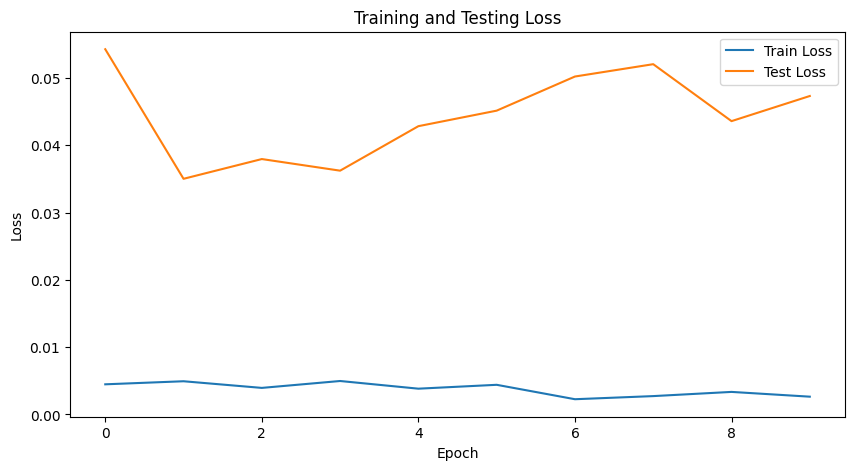

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
# Guardar el modelo

from pathlib import Path
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "mnist_cnn_model.pth"
model_save_path = model_path / model_name
print(f"Guardando modelo en {model_save_path}")

torch.save(model.state_dict(), model_save_path)



Guardando modelo en models\mnist_cnn_model.pth


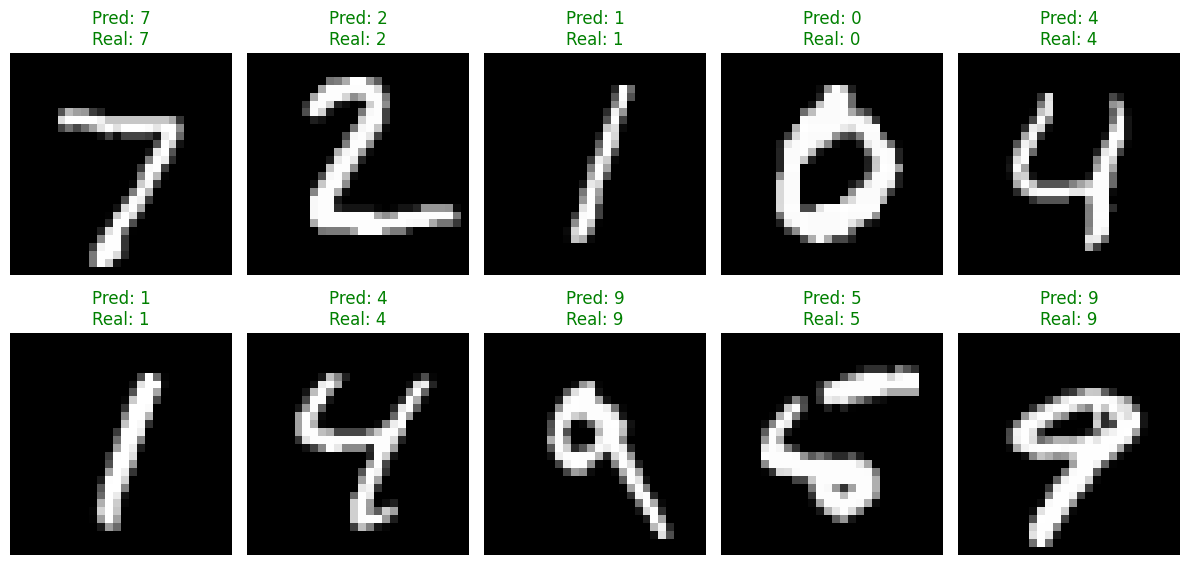

In [29]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.inference_mode():
    # Obtener un batch del test set
    images, labels = next(iter(test_loader))
    images_gpu = images.to(device)
    
    # Hacer predicciones
    outputs = model(images_gpu)
    _, predicted = outputs.max(dim=1)
    
    # Visualizar las primeras 10 imágenes
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(10):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Pred: {predicted[i].item()}\nReal: {labels[i].item()}',
                         color='green' if predicted[i] == labels[i] else 'red')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()